# SETUP


In [1]:
%%capture
!pip install xarray
!pip install wandb
!pip install collections
!pip install pysteps
!pip install beartype
!pip install scikit-image
!pip install netcdf4
!pip install cartopy

In [2]:
import os
new_directory = '/dss/dsshome1/0D/ge74xuf2/climate_diffusion'
os.chdir(new_directory)
os.getcwd()

'/dss/dsshome1/0D/ge74xuf2/climate_diffusion'

In [3]:
from torch.utils.data import DataLoader, Subset

In [4]:
import math
import copy
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import xarray as xr
import wandb
import IPython.display as display
import logging
import torch.nn.functional as F
import collections
import copy
import torchvision.transforms as transforms


from PIL import Image
from torch import optim
from PIL import Image
from torch.utils import data
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import random_split
from inspect import isfunction
from functools import partial
from abc import abstractmethod
from skimage.metrics import structural_similarity as ssim
from pysteps.utils.spectral import rapsd, corrcoef
import matplotlib.ticker as ticker

from src.utils import *
from src.utils_essential import *
from src.base_network import BaseNetwork
from src.imagen_unet import *
from src.helper import *
from tqdm import tqdm


from src.dataloader_sr import gfdl_eval_256, era5_upscaled_1d_256, era5_0_25d_256, qm_gfdl_trafo_units_hr
from src.dataloader_sr import QM_GFDL_LR_Dataset_256

Pysteps configuration file found at: /usr/local/lib/python3.10/dist-packages/pysteps/pystepsrc



/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data

In [5]:
era5_hr_ds = era5_0_25d_256(stage='train')

In [6]:
save_folder = "/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_2_ensemble"

# Initialize a list to store the loaded ensemble runs
ensemble_outputs2 = []

# Load all ensemble runs from the folder
for i in range(1, 51):  # Assuming you have 50 ensemble runs saved as ensemble_1.pt, ensemble_2.pt, ...
    file_path = os.path.join(save_folder, f"ensemble_{i}.pt")
    
    if os.path.exists(file_path):
        print(f"Loading {file_path}...")
        ensemble_run = torch.load(file_path, weights_only=True)  # Load the saved tensor
        print("trafo units here")
        ensemble_run = era5_hr_ds.inverse_dwd_trafo(ensemble_run)
        ensemble_outputs2.append(ensemble_run)
    else:
        print(f"File {file_path} does not exist.")

# After loading all ensemble runs, stack them along a new dimension (dim=0)
dm_ensemble_stack = torch.stack(ensemble_outputs2, dim=0).detach().cpu()  # Shape: (50, 365*256*256 or so, ...)

# Now you can proceed with the further analysis or visualization
print(f"DM Ensemble stack shape: {dm_ensemble_stack.shape}")

Loading /dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_2_ensemble/ensemble_1.pt...
trafo units here
Loading /dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_2_ensemble/ensemble_2.pt...
trafo units here
Loading /dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_2_ensemble/ensemble_3.pt...
trafo units here
Loading /dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_2_ensemble/ensemble_4.pt...
trafo units here
Loading /dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_2_ensemble/ensemble_5.pt...
trafo units here
Loading /dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_2_ensemble/ensemble_6.pt...
trafo units here
Loading /dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_2_ensemble/ensemble_7.pt...
trafo units here
Loading /dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_2_ens

In [7]:
save_folder = "/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_2_vq_vae_ensemble"

# Initialize a list to store the loaded ensemble runs
ensemble_outputs2 = []

# Get all files matching the pattern "ensemble_*.pt" and sort them numerically
file_names = [f for f in os.listdir(save_folder) if f.startswith("ensemble_") and f.endswith(".pt")]
file_names_sorted = sorted(file_names, key=lambda x: int(x.split('_')[1].split('.')[0]))

# Load all ensemble runs from the sorted file names
for file_name in file_names_sorted:
    file_path = os.path.join(save_folder, file_name)
    
    if os.path.exists(file_path):
        print(f"Loading {file_path}...")
        ensemble_run = torch.load(file_path, weights_only=True).cpu()  # Load the saved tensor
        print("trafo units here")
        ensemble_run = era5_hr_ds.inverse_dwd_trafo(ensemble_run)
        ensemble_outputs2.append(ensemble_run)
    else:
        print(f"File {file_path} does not exist.")

# After loading all ensemble runs, stack them along a new dimension (dim=0)
vqvae_ensemble_stack = torch.stack(ensemble_outputs2, dim=0).detach().cpu() # Shape: (number_of_files, ...)
print(f"VQVAE Ensemble stack shape: {vqvae_ensemble_stack.shape}")

Loading /dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_2_vq_vae_ensemble/ensemble_1.pt...
trafo units here
Loading /dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_2_vq_vae_ensemble/ensemble_2.pt...
trafo units here
Loading /dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_2_vq_vae_ensemble/ensemble_3.pt...
trafo units here
Loading /dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_2_vq_vae_ensemble/ensemble_4.pt...
trafo units here
Loading /dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_2_vq_vae_ensemble/ensemble_5.pt...
trafo units here
Loading /dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_2_vq_vae_ensemble/ensemble_6.pt...
trafo units here
Loading /dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_2_vq_vae_ensemble/ensemble_7.pt...
trafo units here
Loading /dss/dssfs04/lwp-dss-0002/pn49fu/

In [8]:
era5_p_1d_256_v = era5_upscaled_1d_256(stage='valid')
era5_p_1d_256_v_subset = Subset(era5_p_1d_256_v, range(365))
era5_reference = next(iter(DataLoader(era5_p_1d_256_v_subset, batch_size=365, shuffle=False, drop_last=True)))
era5_lr_reference = era5_p_1d_256_v.inverse_dwd_trafo(era5_reference)
print("era5 lr reference",era5_lr_reference.shape)

era5_p025 = era5_0_25d_256(stage='valid')
era5_p_1d_256_v_subset = Subset(era5_p025, range(365))
dataloader_era5_val_p025 = data.DataLoader(era5_p025, batch_size=365, shuffle=False, drop_last=True)
era5_hr_reference = next(iter(dataloader_era5_val_p025))
era5_hr_reference = era5_p025.inverse_dwd_trafo(era5_hr_reference)
print("era5_hr_reference", era5_hr_reference.shape)


dm_ensemble_mean = dm_ensemble_stack.mean(dim=0)
print("dm ensemble_stack",dm_ensemble_stack.shape)
print("dm ensemble_mean",dm_ensemble_mean.shape)


vqvae_ensemble_mean = vqvae_ensemble_stack.mean(dim=0)
print("vqvae ensemble_stack",vqvae_ensemble_stack.shape)
print("vqvae ensemble_mean",vqvae_ensemble_mean.shape)

era5 lr reference torch.Size([365, 1, 256, 256])
era5_hr_reference torch.Size([365, 1, 256, 256])
dm ensemble_stack torch.Size([50, 365, 1, 256, 256])
dm ensemble_mean torch.Size([365, 1, 256, 256])
vqvae ensemble_stack torch.Size([50, 365, 1, 256, 256])
vqvae ensemble_mean torch.Size([365, 1, 256, 256])


# Compute CRPS

In [9]:
import torch

def crps_from_empirical_cdf(truth: torch.Tensor, ensemble: torch.Tensor) -> torch.Tensor:
    """
    Compute the exact CRPS using the CDF method.

    Uses this formula:
    int [F(x) - 1(x-y)]^2 dx

    where F is the empirical CDF and 1(x-y) = 1 if x > y.

    This method is more memory-efficient than the kernel method, and uses O(n log n) compute instead of O(n^2), 
    where n is the number of ensemble members.

    Args:
        truth: (...) tensor of observations
        ensemble: (N, ...) tensor of ensemble members

    Returns:
        (...,) tensor of CRPS scores
    """

    y = truth
    n = ensemble.shape[0]

    # Sort the ensemble along the first dimension
    ensemble, _ = torch.sort(ensemble, dim=0)

    ans = 0.0

    # Case 1: dx [F(x) - H(x-y)]^2 = dx [0 - 1]^2 = dx
    val = ensemble[0] - y
    ans += torch.where(val > 0, val, torch.tensor(0.0, device=val.device))

    for i in range(n - 1):
        x0 = ensemble[i]
        x1 = ensemble[i + 1]
        cdf = (i + 1) / n

        # Case 2a: y < x0
        val = (x1 - x0) * (cdf - 1) ** 2
        mask = y < x0
        ans += torch.where(mask, val, torch.tensor(0.0, device=val.device))

        # Case 2b: x0 <= y <= x1
        val = (y - x0) * cdf**2 + (x1 - y) * (cdf - 1) ** 2
        mask = (y >= x0) & (y <= x1)
        ans += torch.where(mask, val, torch.tensor(0.0, device=val.device))

        # Case 2c: y > x1
        val = (x1 - x0) * cdf**2
        mask = y > x1
        ans += torch.where(mask, val, torch.tensor(0.0, device=val.device))

    # Case 3: dx [F(x) - H(x-y)]^2 = dx [1 - 0]^2 = dx
    val = y - ensemble[-1]
    ans += torch.where(val > 0, val, torch.tensor(0.0, device=val.device))

    return ans

In [10]:
#ensamble = [0.69, 1.25, 0.36, -0.11, -0.19]
#crps_from_empirical_cdf(ensamble, -1) = 1.1056
#crps_from_empirical_cdf(ensamble, 0) = 0.2256
#crps_from_empirical_cdf(ensamble, 1) = 0.4056

In [11]:
ensemble = torch.tensor([0.69, 1.25, 0.36, -0.11, -0.19]).view(-1, 1)
truth = torch.tensor([0]).view(-1, 1)

crps_score = crps_from_empirical_cdf(truth, ensemble)
print(f"CRPS Score: {crps_score}")

CRPS Score: tensor([[0.2256]])


In [12]:
ensemble = torch.tensor([0.69, 1.25, 0.36, -0.11, -0.19]).view(-1, 1)
truth = torch.tensor([-1]).view(-1, 1)

crps_score = crps_from_empirical_cdf(truth, ensemble)
print(f"CRPS Score: {crps_score}")

CRPS Score: tensor([[1.1056]])


In [13]:
ensemble = torch.tensor([0.69, 1.25, 0.36, -0.11, -0.19]).view(-1, 1)
truth = torch.tensor([1]).view(-1, 1)

# Compute CRPS
crps_score = crps_from_empirical_cdf(truth, ensemble)
print(f"CRPS Score: {crps_score}")

CRPS Score: tensor([[0.4056]])


# Evaluate CRPS

In [14]:
n = 365

In [15]:
vqvae_ensemble_stack.shape, era5_hr_reference.shape, dm_ensemble_stack.shape

(torch.Size([50, 365, 1, 256, 256]),
 torch.Size([365, 1, 256, 256]),
 torch.Size([50, 365, 1, 256, 256]))

In [16]:
era5_hr_reference.squeeze(1)[:n].unsqueeze(0).shape, vqvae_ensemble_stack.squeeze(2)[:50,:n,:,:].shape, dm_ensemble_stack.squeeze(2)[:50,:n,:,:].shape

(torch.Size([1, 365, 256, 256]),
 torch.Size([50, 365, 256, 256]),
 torch.Size([50, 365, 256, 256]))

In [17]:
era5_lr_reference.squeeze(1)[:n].unsqueeze(0).shape

torch.Size([1, 365, 256, 256])

In [18]:
bilin_crps = crps_from_empirical_cdf(era5_hr_reference.squeeze(1)[:n].unsqueeze(0), era5_lr_reference.squeeze(1)[:n].unsqueeze(0)).squeeze(0)
vq_crps = crps_from_empirical_cdf(era5_hr_reference.squeeze(1)[:n].unsqueeze(0), vqvae_ensemble_stack.squeeze(2)[:50,:n,:,:]).squeeze(0)
dm_crps = crps_from_empirical_cdf(era5_hr_reference.squeeze(1)[:n].unsqueeze(0), dm_ensemble_stack.squeeze(2)[:50,:n,:,:]).squeeze(0)

In [29]:
vq_crps.shape, bilin_crps.shape, dm_crps.shape

(torch.Size([365, 256, 256]),
 torch.Size([365, 256, 256]),
 torch.Size([365, 256, 256]))

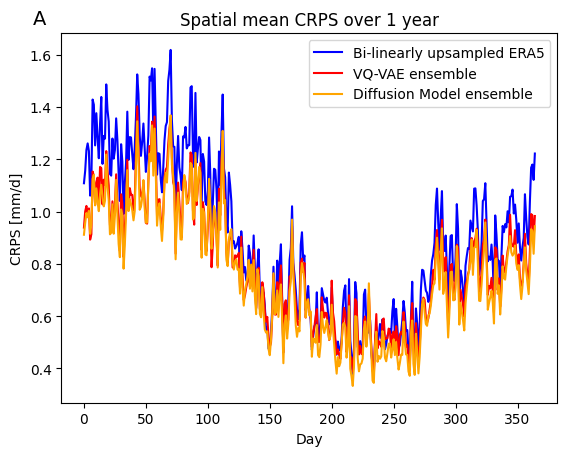

In [20]:
plt.plot(bilin_crps.mean(dim=(1,2)).numpy(), label='Bi-linearly upsampled ERA5', color="blue")
plt.plot(vq_crps.mean(dim=(1,2)).numpy(), label='VQ-VAE ensemble', color="red")
plt.plot(dm_crps.mean(dim=(1,2)).numpy(), label='Diffusion Model ensemble', color="orange")

plt.title('Spatial mean CRPS over 1 year')
plt.xlabel('Day')
plt.ylabel('CRPS [mm/d]')
plt.legend()

# Add "A" label to the top-left corner outside the plot
plt.gcf().text(0.08, 0.93, "A", fontsize=14, va='top', ha='left', fontweight='light')  
#plt.savefig("figures_paper/spatial_mean_crps.pdf", dpi=1000, bbox_inches='tight')
plt.show()

/tmp/ipykernel_2503081/2547027681.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdBu', len(bounds) - 1)


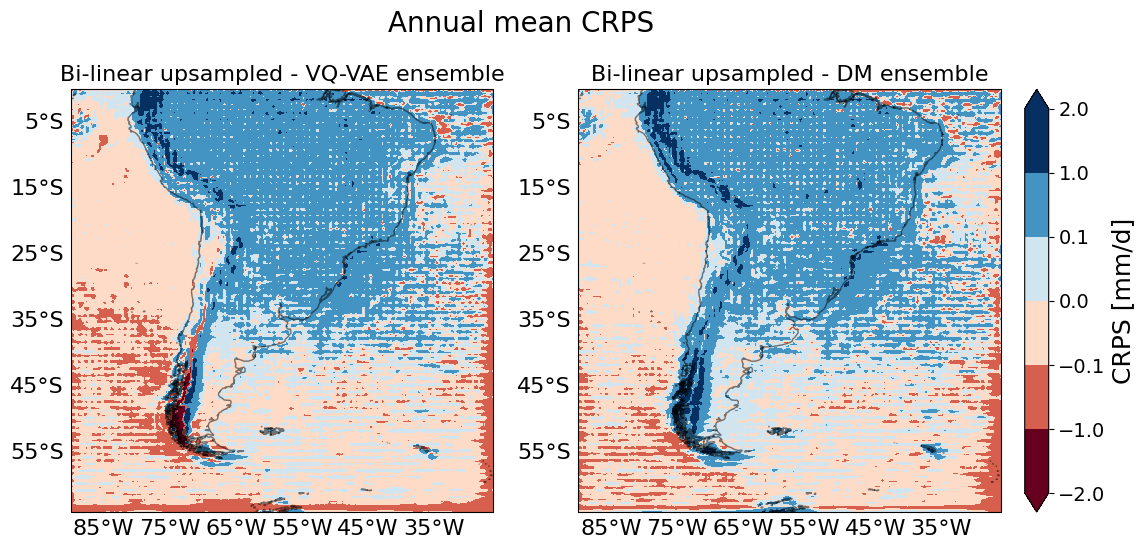

In [70]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import ticker

# Define custom bounds for quantized colorbar
bounds = [-2, -1, -0.1, 0, 0.1, 1, 2]
norm = mcolors.BoundaryNorm(bounds, ncolors=len(bounds) - 1, clip=True)
cmap = cm.get_cmap('RdBu', len(bounds) - 1)

# Create the plot with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

crps_dm_mean = bilin_crps.mean(0).cpu() - dm_crps.mean(0).cpu()
crps_bilin_mean = bilin_crps.mean(0).cpu() - vq_crps.mean(0).cpu()

# Calculate absolute mean CRPS values formatted to always show two decimals
crps_dm_mean_value = f"{crps_dm_mean.abs().mean().item():.2f}"
crps_bilin_mean_value = f"{crps_bilin_mean.abs().mean().item():.2f}"


# Plot CRPS for Bilinear Upscaling
im1 = axes[0].imshow(crps_bilin_mean, cmap=cmap, norm=norm, origin='upper', extent=[-90, -26, -64, 0])
axes[0].set_title(f"Bi-linear upsampled - VQ-VAE ensemble", fontsize=16)
axes[0].coastlines(resolution='10m', color='black', linewidth=1, alpha=0.5)
axes[0].add_feature(cfeature.LAND, color='lightgray')

# Plot CRPS for Diffusion Model
im2 = axes[1].imshow(crps_dm_mean, cmap=cmap, norm=norm, origin='upper', extent=[-90, -26, -64, 0])
axes[1].set_title(f"Bi-linear upsampled - DM ensemble", fontsize=16)
axes[1].coastlines(resolution='10m', color='black', linewidth=1, alpha=0.5)
axes[1].add_feature(cfeature.LAND, color='lightgray')

# Add gridlines and labels
for ax in axes:
    ax.set_extent([-90, -26, -64, 0], crs=ccrs.PlateCarree())
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlocator = ticker.FixedLocator([-35, -45, -55, -65, -75, -85])
    gl.ylocator = ticker.FixedLocator([-5, -15, -25, -35, -45, -55, -65])
    gl.xlabel_style = {'size': 16}
    gl.ylabel_style = {'size': 16}

# Add a single shared quantized colorbar
bbox = axes[0].get_position()
colorbar_height = bbox.height
cbar_ax = fig.add_axes([0.92, bbox.y0, 0.02, colorbar_height])  # Center the colorbar vertically and set its size
cbar = fig.colorbar(im1, cax=cbar_ax, extend="both", orientation="vertical", boundaries=bounds, ticks=bounds)
cbar.ax.tick_params(labelsize=14)
cbar.set_label("CRPS [mm/d]", fontsize=18)
plt.suptitle("Annual mean CRPS", fontsize=20)
#plt.savefig("figures_paper/annual_crps.pdf", dpi=1000,bbox_inches='tight')
plt.show()

/tmp/ipykernel_2503081/4106337317.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', len(bounds) - 1)


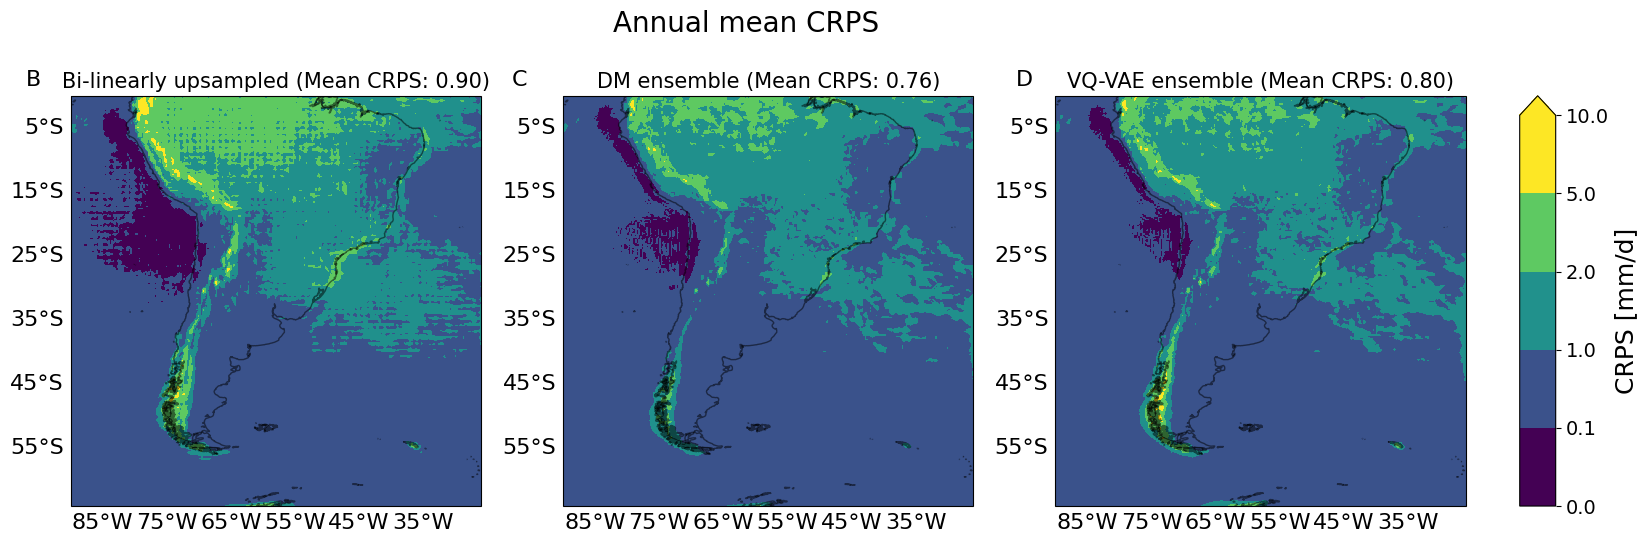

In [58]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import ticker

# Define custom bounds for quantized colorbar
bounds = [0, 0.1, 1, 2, 5, 10]
norm = mcolors.BoundaryNorm(bounds, ncolors=len(bounds) - 1, clip=True)
cmap = cm.get_cmap('viridis', len(bounds) - 1)

# Create the plot with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Calculate mean CRPS values
crps_dm_mean = dm_crps.mean(0).cpu()
crps_bilin_mean = bilin_crps.mean(0).cpu()
crps_vq_mean = vq_crps.mean(0).cpu()

# Format mean CRPS values to always show two decimals
crps_dm_mean_value = f"{crps_dm_mean.mean().item():.2f}"
crps_bilin_mean_value = f"{crps_bilin_mean.mean().item():.2f}"
crps_vq_mean_value = f"{crps_vq_mean.mean().item():.2f}"

# Plot CRPS for Bilinear Upscaling
im1 = axes[0].imshow(crps_bilin_mean, cmap=cmap, norm=norm, origin='upper', extent=[-90, -26, -64, 0])
axes[0].set_title(f"Bi-linearly upsampled (Mean CRPS: {crps_bilin_mean_value})", fontsize=15)
axes[0].coastlines(resolution='10m', color='black', linewidth=1, alpha=0.5)
axes[0].add_feature(cfeature.LAND, color='lightgray')

# Plot CRPS for Diffusion Model
im2 = axes[1].imshow(crps_dm_mean, cmap=cmap, norm=norm, origin='upper', extent=[-90, -26, -64, 0])
axes[1].set_title(f"DM ensemble (Mean CRPS: {crps_dm_mean_value})", fontsize=15)
axes[1].coastlines(resolution='10m', color='black', linewidth=1, alpha=0.5)
axes[1].add_feature(cfeature.LAND, color='lightgray')

# Plot CRPS for VQ-VAE Benchmark
im3 = axes[2].imshow(crps_vq_mean, cmap=cmap, norm=norm, origin='upper', extent=[-90, -26, -64, 0])
axes[2].set_title(f"VQ-VAE ensemble (Mean CRPS: {crps_vq_mean_value})", fontsize=15)
axes[2].coastlines(resolution='10m', color='black', linewidth=1, alpha=0.5)
axes[2].add_feature(cfeature.LAND, color='lightgray')

# Add gridlines and labels to all subplots
for ax in axes:
    ax.set_extent([-90, -26, -64, 0], crs=ccrs.PlateCarree())
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlocator = ticker.FixedLocator([-35, -45, -55, -65, -75, -85])
    gl.ylocator = ticker.FixedLocator([-5, -15, -25, -35, -45, -55, -65])
    gl.xlabel_style = {'size': 16}
    gl.ylabel_style = {'size': 16}

# Add a single shared quantized colorbar
bbox = axes[0].get_position()
colorbar_height = bbox.height
cbar_ax = fig.add_axes([0.93, bbox.y0, 0.02, colorbar_height])  # Adjusted for three plots
cbar = fig.colorbar(im1, cax=cbar_ax, extend="max", orientation="vertical", boundaries=bounds, ticks=bounds)
cbar.ax.tick_params(labelsize=14)
cbar.set_label("CRPS [mm/d]", fontsize=18)

fig.text(0.1, 0.88, "B", fontsize=16, fontweight='light', va='top', ha='left')  # Label for first subplot
fig.text(0.37, 0.88, "C", fontsize=16, fontweight='light', va='top', ha='left')  # Label for second subplot
fig.text(0.65, 0.88, "D", fontsize=16, fontweight='light', va='top', ha='left')  # Label for third subplot

plt.suptitle("Annual mean CRPS", fontsize=20)
#plt.savefig("figures_paper/annual_crps.pdf", dpi=1000, bbox_inches='tight')
plt.show()